# POS_CASH_balance.csv

+ Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
+ This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

# credit_card_balance.csv

+ Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
+ This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

# previous_application.csv

+ All previous applications for Home Credit loans of clients who have loans in our sample.
+ There is one row for each previous application related to loans in our data sample.

# installments_payments.csv

+ Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
+ There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import scipy
import itertools

['POS_CASH_balance.csv', 'bureau_balance.csv', 'application_train.csv', 'previous_application.csv', 'installments_payments.csv', 'credit_card_balance.csv', 'sample_submission.csv', 'application_test.csv', 'bureau.csv']


In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
plt.style.use('fivethirtyeight')

In [4]:
installments_payments = reduce_mem_usage(pd.read_csv('../input/installments_payments.csv'))
POS_CASH_balance = reduce_mem_usage(pd.read_csv('../input/POS_CASH_balance.csv'))
credit_card_balance = reduce_mem_usage(pd.read_csv('../input/credit_card_balance.csv'))
previous_application = reduce_mem_usage(pd.read_csv('../input/previous_application.csv'))
application_train = reduce_mem_usage(pd.read_csv('../input/application_train.csv'))
application_test = reduce_mem_usage(pd.read_csv('../input/application_test.csv'))

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 389.25 MB
Decreased by 53.1%
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 276.60 MB
Decreased by 54.7%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 318.63 MB
Decreased by 52.7%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 324.94 MB
Decreased by 31.1%
Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 128.16 MB
Decreased by 55.2%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 20.27 MB
Decreased by 55.0%


# SK_ID_CURR Comparison

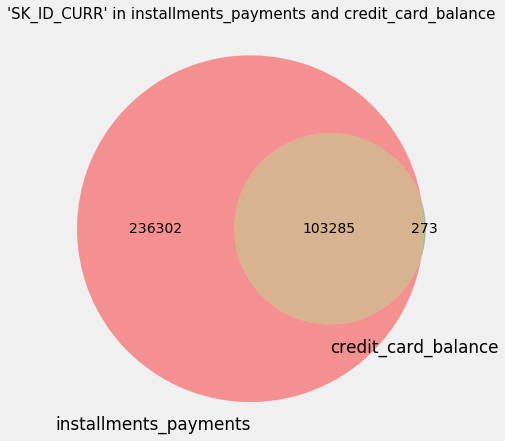

/opt/conda/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


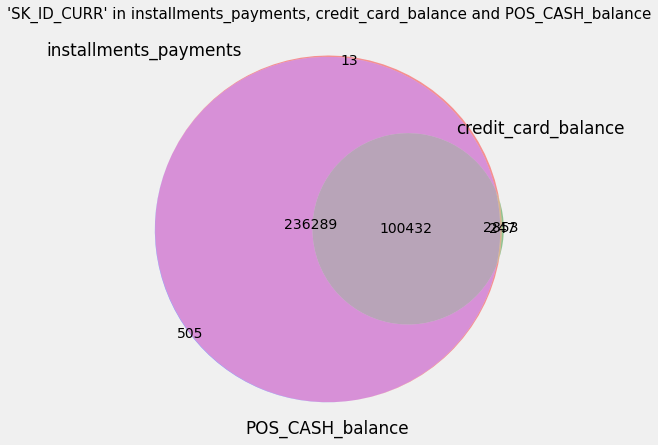

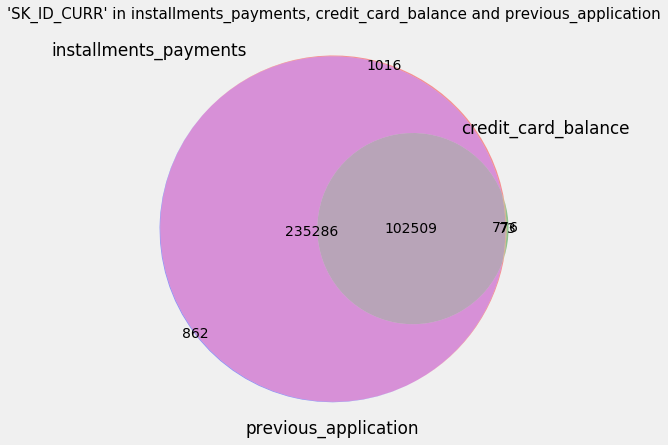

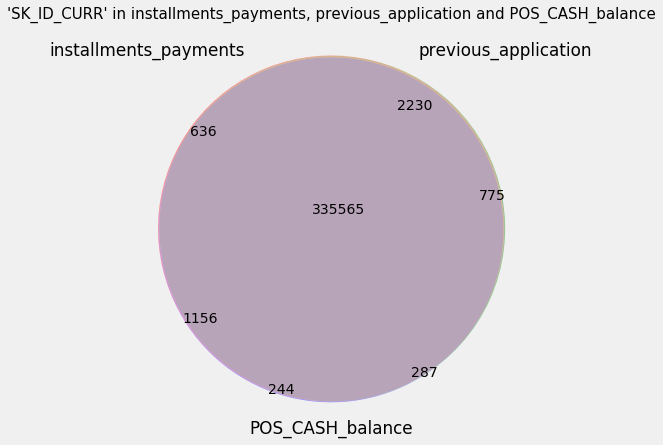

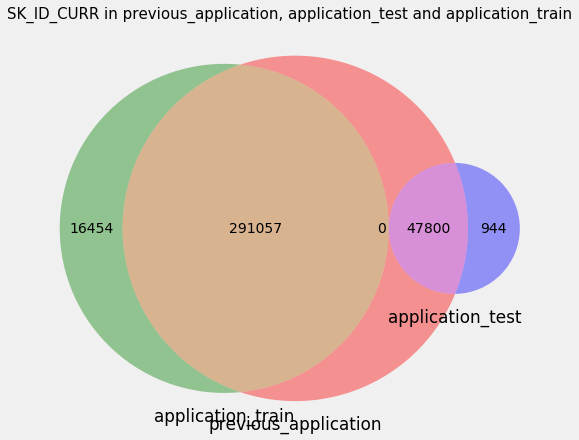

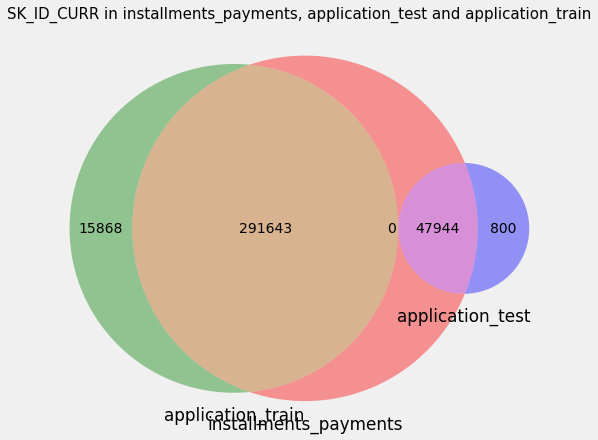

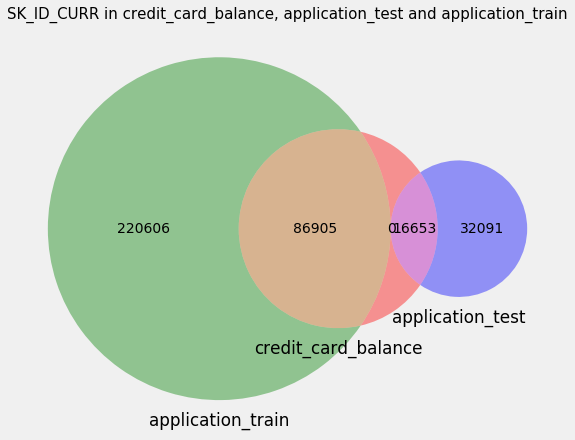

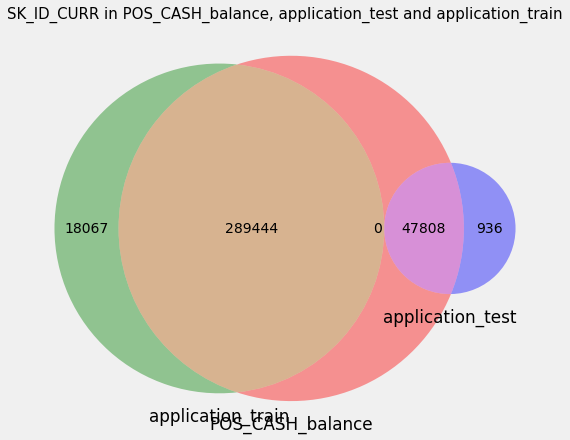

In [5]:
plt.figure(figsize=(10,7))
venn2([set(installments_payments['SK_ID_CURR'].unique()), set(credit_card_balance['SK_ID_CURR'].unique())], set_labels = ('installments_payments', 'credit_card_balance') )
plt.title("'SK_ID_CURR' in installments_payments and credit_card_balance", fontsize=15)
plt.show()

plt.figure(figsize=(10,7))
venn3([set(installments_payments['SK_ID_CURR'].unique()), set(credit_card_balance['SK_ID_CURR'].unique()), set(POS_CASH_balance['SK_ID_CURR'].unique())], set_labels = ('installments_payments', 'credit_card_balance', 'POS_CASH_balance') )
plt.title("'SK_ID_CURR' in installments_payments, credit_card_balance and POS_CASH_balance", fontsize=15)
plt.show()

plt.figure(figsize=(10,7))
venn3([set(installments_payments['SK_ID_CURR'].unique()), set(credit_card_balance['SK_ID_CURR'].unique()), set(previous_application['SK_ID_CURR'].unique())], set_labels = ('installments_payments', 'credit_card_balance', 'previous_application') )
plt.title("'SK_ID_CURR' in installments_payments, credit_card_balance and previous_application", fontsize=15)
plt.show()

plt.figure(figsize=(10,7))
venn3([set(installments_payments['SK_ID_CURR'].unique()), set(previous_application['SK_ID_CURR'].unique()), set(POS_CASH_balance['SK_ID_CURR'].unique())], set_labels = ('installments_payments', 'previous_application', 'POS_CASH_balance') )
plt.title("'SK_ID_CURR' in installments_payments, previous_application and POS_CASH_balance", fontsize=15)
plt.show()

plt.figure(figsize=(10,7))
venn3([set(previous_application['SK_ID_CURR'].unique()), set(application_train['SK_ID_CURR'].unique()), set(application_test['SK_ID_CURR'].unique())], set_labels = ('previous_application', 'application_train', 'application_test') )
plt.title("SK_ID_CURR in previous_application, application_test and application_train", fontsize=15)
plt.show()

plt.figure(figsize=(10,7))
venn3([set(installments_payments['SK_ID_CURR'].unique()), set(application_train['SK_ID_CURR'].unique()), set(application_test['SK_ID_CURR'].unique())], set_labels = ('installments_payments', 'application_train', 'application_test') )
plt.title("SK_ID_CURR in installments_payments, application_test and application_train", fontsize=15)
plt.show()

plt.figure(figsize=(10,7))
venn3([set(credit_card_balance['SK_ID_CURR'].unique()), set(application_train['SK_ID_CURR'].unique()), set(application_test['SK_ID_CURR'].unique())], set_labels = ('credit_card_balance', 'application_train', 'application_test') )
plt.title("SK_ID_CURR in credit_card_balance, application_test and application_train", fontsize=15)
plt.show()

plt.figure(figsize=(10,7))
venn3([set(POS_CASH_balance['SK_ID_CURR'].unique()), set(application_train['SK_ID_CURR'].unique()), set(application_test['SK_ID_CURR'].unique())], set_labels = ('POS_CASH_balance', 'application_train', 'application_test') )
plt.title("SK_ID_CURR in POS_CASH_balance, application_test and application_train", fontsize=15)
plt.show()

# SK_ID_PREV Comparison

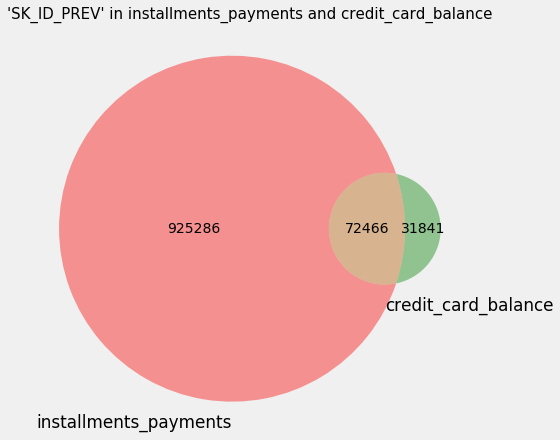

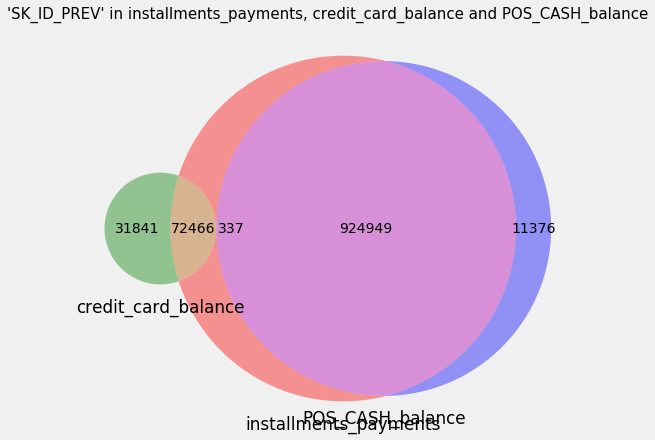

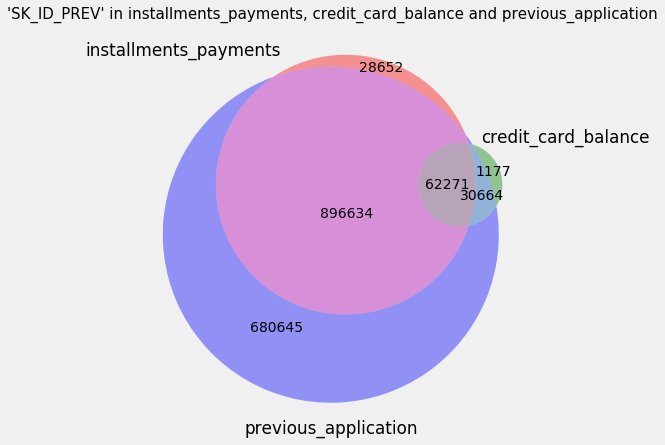

In [6]:
plt.figure(figsize=(10,7))
venn2([set(installments_payments['SK_ID_PREV'].unique()), set(credit_card_balance['SK_ID_PREV'].unique())], set_labels = ('installments_payments', 'credit_card_balance') )
plt.title("'SK_ID_PREV' in installments_payments and credit_card_balance", fontsize=15)
plt.show()

plt.figure(figsize=(10,7))
venn3([set(installments_payments['SK_ID_PREV'].unique()), set(credit_card_balance['SK_ID_PREV'].unique()), set(POS_CASH_balance['SK_ID_PREV'].unique())], set_labels = ('installments_payments', 'credit_card_balance', 'POS_CASH_balance') )
plt.title("'SK_ID_PREV' in installments_payments, credit_card_balance and POS_CASH_balance", fontsize=15)
plt.show()

plt.figure(figsize=(10,7))
venn3([set(installments_payments['SK_ID_PREV'].unique()), set(credit_card_balance['SK_ID_PREV'].unique()), set(previous_application['SK_ID_PREV'].unique())], set_labels = ('installments_payments', 'credit_card_balance', 'previous_application') )
plt.title("'SK_ID_PREV' in installments_payments, credit_card_balance and previous_application", fontsize=15)
plt.show()

In [7]:
del application_train, application_test

In [8]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
SK_ID_PREV                    int32
SK_ID_CURR                    int32
MONTHS_BALANCE                int8
AMT_BALANCE                   float32
AMT_CREDIT_LIMIT_ACTUAL       int32
AMT_DRAWINGS_ATM_CURRENT      float32
AMT_DRAWINGS_CURRENT          float32
AMT_DRAWINGS_OTHER_CURRENT    float32
AMT_DRAWINGS_POS_CURRENT      float32
AMT_INST_MIN_REGULARITY       float32
AMT_PAYMENT_CURRENT           float32
AMT_PAYMENT_TOTAL_CURRENT     float32
AMT_RECEIVABLE_PRINCIPAL      float32
AMT_RECIVABLE                 float32
AMT_TOTAL_RECEIVABLE          float32
CNT_DRAWINGS_ATM_CURRENT      float32
CNT_DRAWINGS_CURRENT          int16
CNT_DRAWINGS_OTHER_CURRENT    float32
CNT_DRAWINGS_POS_CURRENT      float32
CNT_INSTALMENT_MATURE_CUM     float32
NAME_CONTRACT_STATUS          object
SK_DPD                        int16
SK_DPD_DEF                    int16
dtypes: float32(15), int16(3)

In [9]:
installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
SK_ID_PREV                int32
SK_ID_CURR                int32
NUM_INSTALMENT_VERSION    float32
NUM_INSTALMENT_NUMBER     int16
DAYS_INSTALMENT           float32
DAYS_ENTRY_PAYMENT        float32
AMT_INSTALMENT            float32
AMT_PAYMENT               float32
dtypes: float32(5), int16(1), int32(2)
memory usage: 389.3 MB


In [10]:
credit_card_balance.sort_values(by=['SK_ID_CURR','MONTHS_BALANCE'], ascending=[True, False]).head(15)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
584804,1489396,100006,-1,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
520387,1489396,100006,-2,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
1347528,1489396,100006,-3,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
1399895,1489396,100006,-4,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
655566,1489396,100006,-5,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
1636141,1489396,100006,-6,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
2739019,1843384,100011,-2,0.0,90000,0.0,0.0,0.0,0.0,0.0,563.35498,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,33.0,Active,0,0
3496910,1843384,100011,-3,0.0,90000,0.0,0.0,0.0,0.0,0.0,563.35498,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,33.0,Active,0,0
51047,1843384,100011,-4,0.0,90000,0.0,0.0,0.0,0.0,0.0,563.35498,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,33.0,Active,0,0
2674883,1843384,100011,-5,0.0,90000,0.0,0.0,0.0,0.0,0.0,563.35498,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,33.0,Active,0,0


In [11]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [12]:
installments_payments.shape, credit_card_balance.shape

((13605401, 8), (3840312, 23))

In [13]:
#credit_card_balance_agg = credit_card_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
credit_card_balance_agg = credit_card_balance.drop('SK_ID_PREV', axis=1).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
credit_card_balance_agg.head()

SK_ID_CURR MONTHS_BALANCE                       AMT_BALANCE                                              AMT_CREDIT_LIMIT_ACTUAL                                          AMT_DRAWINGS_ATM_CURRENT                                       AMT_DRAWINGS_CURRENT                                       AMT_DRAWINGS_OTHER_CURRENT                     AMT_DRAWINGS_POS_CURRENT                     AMT_INST_MIN_REGULARITY                                          AMT_PAYMENT_CURRENT                                        AMT_PAYMENT_TOTAL_CURRENT                                          AMT_RECEIVABLE_PRINCIPAL                                          AMT_RECIVABLE                                                      AMT_TOTAL_RECEIVABLE                                                      CNT_DRAWINGS_ATM_CURRENT                           CNT_DRAWINGS_CURRENT                       CNT_DRAWINGS_OTHER_CURRENT                     CNT_DRAWINGS_POS_CURRENT                     CNT_INSTALMENT_MATURE_CUM                               SK_DPD                        SK_DPD_DEF                       
                      count  mean max min     sum       count          mean           max  min         sum                   count           mean     max     min       sum                    count         mean       max  min       sum                count         mean       max  min       sum                      count mean  max  min  sum                    count mean  max  min  sum                   count         mean     max  min            sum               count         mean       max  min        sum                     count         mean       max  min          sum                    count          mean       max  min         sum         count          mean           max         min          sum                count          mean           max         min          sum                    count      mean  max  min   sum                count      mean max min sum                      count mean  max  min  sum                    count mean  max  min  sum                     count       mean   max  min     sum  count      mean max min  sum      count      mean max min  sum
0     100006              6  -3.5  -1  -6   -21.0           6      0.000000       0.00000  0.0        0.00                       6  270000.000000  270000  270000   1620000                        0          NaN       NaN  NaN       0.0                    6     0.000000       0.0  0.0       0.0                          0  NaN  NaN  NaN  0.0                        0  NaN  NaN  NaN  0.0                       6     0.000000     0.0  0.0       0.000000                   0          NaN       NaN  NaN       0.00                         6     0.000000       0.0  0.0       0.0000                        6      0.000000       0.0  0.0        0.00             6      0.000000       0.00000    0.000000        0.000                    6      0.000000       0.00000    0.000000        0.000                        0       NaN  NaN  NaN   0.0                    6  0.000000   0   0   0                          0  NaN  NaN  NaN  0.0                        0  NaN  NaN  NaN  0.0                         6   0.000000   0.0  0.0     0.0      6  0.000000   0   0  0.0          6  0.000000   0   0  0.0
1     100011             74 -38.5  -2 -75 -2849.0          74  54482.109375  189000.00000  0.0  4031676.25                      74  164189.189189  180000   90000  12150000                       74  2432.432373  180000.0  0.0  180000.0                   74  2432.432373  180000.0  0.0  180000.0                         74  0.0  0.0  0.0  0.0                       74  0.0  0.0  0.0  0.0                      73  3956.221924  9000.0  0.0  288804.187500                  74  4843.063965   55485.0  0.0  358386.75                        74  4520.067383   55485.0  0.0  334485.0000                       74  52402.089844  180000.0  0.0  3877754.50            74  54433.179688  189000.00000 -563.354980  4028055.250                   74  

In [14]:
#columns = ['SK_ID_CURR', 'SK_ID_PREV']
columns = ['SK_ID_CURR']
# Iterate through the variables names
for var in credit_card_balance_agg.columns.levels[0]:
    # Skip the id name
    #if var != 'SK_ID_CURR' and var != 'SK_ID_PREV':
    if var != 'SK_ID_CURR':
        # Iterate through the stat names
        for stat in credit_card_balance_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('credit_%s_%s' % (var, stat))

In [15]:
credit_card_balance_agg.columns = columns
credit_card_balance_agg.head()

,SK_ID_CURR,credit_MONTHS_BALANCE_count,credit_MONTHS_BALANCE_mean,credit_MONTHS_BALANCE_max,credit_MONTHS_BALANCE_min,credit_MONTHS_BALANCE_sum,credit_AMT_BALANCE_count,credit_AMT_BALANCE_mean,credit_AMT_BALANCE_max,credit_AMT_BALANCE_min,credit_AMT_BALANCE_sum,credit_AMT_CREDIT_LIMIT_ACTUAL_count,credit_AMT_CREDIT_LIMIT_ACTUAL_mean,credit_AMT_CREDIT_LIMIT_ACTUAL_max,credit_AMT_CREDIT_LIMIT_ACTUAL_min,credit_AMT_CREDIT_LIMIT_ACTUAL_sum,credit_AMT_DRAWINGS_ATM_CURRENT_count,credit_AMT_DRAWINGS_ATM_CURRENT_mean,credit_AMT_DRAWINGS_ATM_CURRENT_max,credit_AMT_DRAWINGS_ATM_CURRENT_min,credit_AMT_DRAWINGS_ATM_CURRENT_sum,credit_AMT_DRAWINGS_CURRENT_count,credit_AMT_DRAWINGS_CURRENT_mean,credit_AMT_DRAWINGS_CURRENT_max,credit_AMT_DRAWINGS_CURRENT_min,credit_AMT_DRAWINGS_CURRENT_sum,credit_AMT_DRAWINGS_OTHER_CURRENT_count,credit_AMT_DRAWINGS_OTHER_CURRENT_mean,credit_AMT_DRAWINGS_OTHER_CURRENT_max,credit_AMT_DRAWINGS_OTHER_CURRENT_min,credit_AMT_DRAWINGS_OTHER_CURRENT_sum,credit_AMT_DRAWINGS_POS_CURRENT_count,credit_AMT_DRAWINGS_POS_CURRENT_mean,credit_AMT_DRAWINGS_POS_CURRENT_max,credit_AMT_DRAWINGS_POS_CURRENT_min,credit_AMT_DRAWINGS_POS_CURRENT_sum,credit_AMT_INST_MIN_REGULARITY_count,credit_AMT_INST_MIN_REGULARITY_mean,credit_AMT_INST_MIN_REGULARITY_max,credit_AMT_INST_MIN_REGULARITY_min,credit_AMT_INST_MIN_REGULARITY_sum,credit_AMT_PAYMENT_CURRENT_count,credit_AMT_PAYMENT_CURRENT_mean,credit_AMT_PAYMENT_CURRENT_max,credit_AMT_PAYMENT_CURRENT_min,credit_AMT_PAYMENT_CURRENT_sum,credit_AMT_PAYMENT_TOTAL_CURRENT_count,credit_AMT_PAYMENT_TOTAL_CURRENT_mean,credit_AMT_PAYMENT_TOTAL_CURRENT_max,credit_AMT_PAYMENT_TOTAL_CURRENT_min,credit_AMT_PAYMENT_TOTAL_CURRENT_sum,credit_AMT_RECEIVABLE_PRINCIPAL_count,credit_AMT_RECEIVABLE_PRINCIPAL_mean,credit_AMT_RECEIVABLE_PRINCIPAL_max,credit_AMT_RECEIVABLE_PRINCIPAL_min,credit_AMT_RECEIVABLE_PRINCIPAL_sum,credit_AMT_RECIVABLE_count,credit_AMT_RECIVABLE_mean,credit_AMT_RECIVABLE_max,credit_AMT_RECIVABLE_min,credit_AMT_RECIVABLE_sum,credit_AMT_TOTAL_RECEIVABLE_count,credit_AMT_TOTAL_RECEIVABLE_mean,credit_AMT_TOTAL_RECEIVABLE_max,credit_AMT_TOTAL_RECEIVABLE_min,credit_AMT_TOTAL_RECEIVABLE_sum,credit_CNT_DRAWINGS_ATM_CURRENT_count,credit_CNT_DRAWINGS_ATM_CURRENT_mean,credit_CNT_DRAWINGS_ATM_CURRENT_max,credit_CNT_DRAWINGS_ATM_CURRENT_min,credit_CNT_DRAWINGS_ATM_CURRENT_sum,credit_CNT_DRAWINGS_CURRENT_count,credit_CNT_DRAWINGS_CURRENT_mean,credit_CNT_DRAWINGS_CURRENT_max,credit_CNT_DRAWINGS_CURRENT_min,credit_CNT_DRAWINGS_CURRENT_sum,credit_CNT_DRAWINGS_OTHER_CURRENT_count,credit_CNT_DRAWINGS_OTHER_CURRENT_mean,credit_CNT_DRAWINGS_OTHER_CURRENT_max,credit_CNT_DRAWINGS_OTHER_CURRENT_min,credit_CNT_DRAWINGS_OTHER_CURRENT_sum,credit_CNT_DRAWINGS_POS_CURRENT_count,credit_CNT_DRAWINGS_POS_CURRENT_mean,credit_CNT_DRAWINGS_POS_CURRENT_max,credit_CNT_DRAWINGS_POS_CURRENT_min,credit_CNT_DRAWINGS_POS_CURRENT_sum,credit_CNT_INSTALMENT_MATURE_CUM_count,credit_CNT_INSTALMENT_MATURE_CUM_mean,credit_CNT_INSTALMENT_MATURE_CUM_max,credit_CNT_INSTALMENT_MATURE_CUM_min,credit_CNT_INSTALMENT_MATURE_CUM_sum,credit_SK_DPD_count,credit_SK_DPD_mean,credit_SK_DPD_max,credit_SK_DPD_min,credit_SK_DPD_sum,credit_SK_DPD_DEF_count,credit_SK_DPD_DEF_mean,credit_SK_DPD_DEF_max,credit_SK_DPD_DEF_min,credit_SK_DPD_DEF_sum
0,100006,6,-3.5,-1,-6,-21.0,6,0.000000,0.00000,0.0,0.00,6,270000.000000,270000,270000,1620000,0,NaN,NaN,NaN,0.0,6,0.000000,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,6,0.000000,0.0,0.0,0.000000,0,NaN,NaN,NaN,0.00,6,0.000000,0.0,0.0,0.0000,6,0.000000,0.0,0.0,0.00,6,0.000000,0.00000,0.000000,0.000,6,0.000000,0.00000,0.000000,0.000,0,NaN,NaN,NaN,0.0,6,0.000000,0,0,0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,6,0.000000,0.0,0.0,0.0,6,0.000000,0,0,0.0,6,0.000000,0,0,0.0
1,100011,74,-38.5,-2,-75,-2849.0,74,54482.109375,189000.00000,0.0,4031676.25,74,164189.189189,180000,90000,12150000,74,2432.432373,180000.0,0.0,180000.0,74,2432.432373,180000.0,0.0,180000.0,74,0.0,0.0,0.0,0.0,74,0.0,0.0,0.0,0.0,73,3956.221924,9000.0,0.0,2

In [16]:
credit_card_balance_agg.shape

(103558, 101)

In [17]:
#installments_payments_agg = installments_payments.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
installments_payments_agg = installments_payments.drop('SK_ID_PREV', axis=1).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
installments_payments_agg.head()

SK_ID_CURR NUM_INSTALMENT_VERSION                           NUM_INSTALMENT_NUMBER                           DAYS_INSTALMENT                                       DAYS_ENTRY_PAYMENT                                       AMT_INSTALMENT                                                         AMT_PAYMENT                                                        
                              count      mean  max  min   sum                 count       mean max min    sum           count         mean     max     min      sum              count         mean     max     min      sum          count          mean            max          min           sum       count          mean            max          min           sum
0     100001                      7  1.142857  2.0  1.0   8.0                     7   2.714286   4   1   19.0               7 -2187.714355 -1619.0 -2916.0 -15314.0                  7 -2195.000000 -1628.0 -2916.0 -15365.0              7   5885.132324   17397.900391  3951.000000  4.119593e+04           7   5885.132324   17397.900391  3951.000000  4.119593e+04
1     100002                     19  1.052632  2.0  1.0  20.0                    19  10.000000  19   1  190.0              19  -295.000000   -25.0  -565.0  -5605.0                 19  -315.421051   -49.0  -587.0  -5993.0             19  11559.247070   53093.746094  9251.775391  2.196257e+05          19  11559.247070   53093.746094  9251.775391  2.196257e+05
2     100003                     25  1.040000  2.0  1.0  26.0                    25   5.080000  12   1  127.0              25 -1378.160034  -536.0 -2310.0 -34454.0                 25 -1385.319946  -544.0 -2324.0 -34633.0             25  64754.585938  560835.375000  6662.970215  1.618865e+06          25  64754.585938  560835.375000  6662.970215  1.618865e+06
3     100004                      3  1.333333  2.0  1.0   4.0                     3   2.000000   3   1    6.0               3  -754.000000  -724.0  -784.0  -2262.0                  3  -761.666687  -727.0  -795.0  -2285.0              3   7096.154785   10573.964844  5357.250000  2.128846e+04           3   7096.154785   10573.964844  5357.250000  2.128846e+04
4     100005                      9  1.111111  2.0  1.0  10.0                     9   5.000000   9   1   45.0               9  -586.000000  -466.0  -706.0  -5274.0                  9  -609.555542  -470.0  -736.0  -5486.0              9   6240.205078   17656.244141  4813.200195  5.616184e+04           9   6240.205078   17656.244141  4813.200195  5.616184e+04

In [18]:
#columns = ['SK_ID_CURR', 'SK_ID_PREV']
columns = ['SK_ID_CURR']
# Iterate through the variables names
for var in installments_payments_agg.columns.levels[0]:
    # Skip the id name
    #if var != 'SK_ID_CURR' and var != 'SK_ID_PREV':
     if var != 'SK_ID_CURR':   
        # Iterate through the stat names
        for stat in installments_payments_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('installments_%s_%s' % (var, stat))

In [19]:
installments_payments_agg.columns = columns
installments_payments_agg.head()

,SK_ID_CURR,installments_NUM_INSTALMENT_VERSION_count,installments_NUM_INSTALMENT_VERSION_mean,installments_NUM_INSTALMENT_VERSION_max,installments_NUM_INSTALMENT_VERSION_min,installments_NUM_INSTALMENT_VERSION_sum,installments_NUM_INSTALMENT_NUMBER_count,installments_NUM_INSTALMENT_NUMBER_mean,installments_NUM_INSTALMENT_NUMBER_max,installments_NUM_INSTALMENT_NUMBER_min,installments_NUM_INSTALMENT_NUMBER_sum,installments_DAYS_INSTALMENT_count,installments_DAYS_INSTALMENT_mean,installments_DAYS_INSTALMENT_max,installments_DAYS_INSTALMENT_min,installments_DAYS_INSTALMENT_sum,installments_DAYS_ENTRY_PAYMENT_count,installments_DAYS_ENTRY_PAYMENT_mean,installments_DAYS_ENTRY_PAYMENT_max,installments_DAYS_ENTRY_PAYMENT_min,installments_DAYS_ENTRY_PAYMENT_sum,installments_AMT_INSTALMENT_count,installments_AMT_INSTALMENT_mean,installments_AMT_INSTALMENT_max,installments_AMT_INSTALMENT_min,installments_AMT_INSTALMENT_sum,installments_AMT_PAYMENT_count,installments_AMT_PAYMENT_mean,installments_AMT_PAYMENT_max,installments_AMT_PAYMENT_min,installments_AMT_PAYMENT_sum
0,100001,7,1.142857,2.0,1.0,8.0,7,2.714286,4,1,19.0,7,-2187.714355,-1619.0,-2916.0,-15314.0,7,-2195.000000,-1628.0,-2916.0,-15365.0,7,5885.132324,17397.900391,3951.000000,4.119593e+04,7,5885.132324,17397.900391,3951.000000,4.119593e+04
1,100002,19,1.052632,2.0,1.0,20.0,19,10.000000,19,1,190.0,19,-295.000000,-25.0,-565.0,-5605.0,19,-315.421051,-49.0,-587.0,-5993.0,19,11559.247070,53093.746094,9251.775391,2.196257e+05,19,11559.247070,53093.746094,9251.775391,2.196257e+05
2,100003,25,1.040000,2.0,1.0,26.0,25,5.080000,12,1,127.0,25,-1378.160034,-536.0,-2310.0,-34454.0,25,-1385.319946,-544.0,-2324.0,-34633.0,25,64754.585938,560835.375000,6662.970215,1.618865e+06,25,64754.585938,560835.375000,6662.970215,1.618865e+06
3,100004,3,1.333333,2.0,1.0,4.0,3,2.000000,3,1,6.0,3,-754.000000,-724.0,-784.0,-2262.0,3,-761.666687,-727.0,-795.0,-2285.0,3,7096.154785,10573.964844,5357.250000,2.128846e+04,3,7096.154785,10573.964844,5357.250000,2.128846e+04
4,100005,9,1.111111,2.0,1.0,10.0,9,5.000000,9,1,45.0,9,-586.000000,-466.0,-706.0,-5274.0,9,-609.555542,-470.0,-736.0,-5486.0,9,6240.205078,17656.244141,4813.200195,5.616184e+04,9,6240.205078,17656.244141,4813.200195,5.616184e+04


In [20]:
installments_payments_agg.shape, credit_card_balance_agg.shape

((339587, 31), (103558, 101))

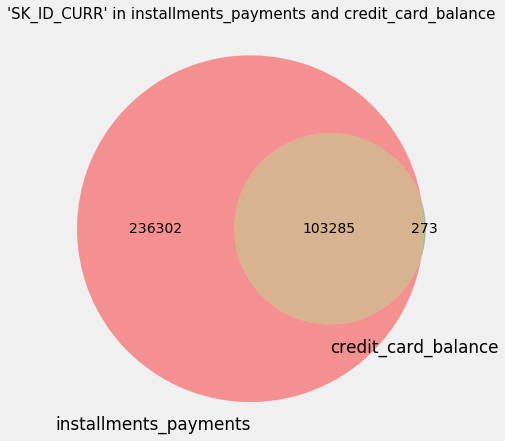

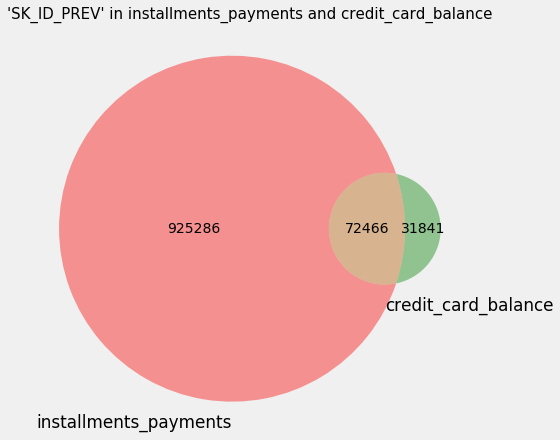

In [21]:
plt.figure(figsize=(10,7))
venn2([set(installments_payments['SK_ID_CURR'].unique()), set(credit_card_balance['SK_ID_CURR'].unique())], set_labels = ('installments_payments', 'credit_card_balance') )
plt.title("'SK_ID_CURR' in installments_payments and credit_card_balance", fontsize=15)
plt.show()

plt.figure(figsize=(10,7))
venn2([set(installments_payments['SK_ID_PREV'].unique()), set(credit_card_balance['SK_ID_PREV'].unique())], set_labels = ('installments_payments', 'credit_card_balance') )
plt.title("'SK_ID_PREV' in installments_payments and credit_card_balance", fontsize=15)
plt.show()

In [22]:
len(installments_payments_agg['SK_ID_CURR'].unique())

339587

In [23]:
#install_credit_agg = installments_payments_agg.merge(credit_card_balance_agg, how='left', on='SK_ID_PREV')
install_credit_agg = installments_payments_agg.merge(credit_card_balance_agg, how='left', on='SK_ID_CURR')

In [24]:
install_credit_agg.shape

(339587, 131)

In [25]:
install_credit_agg = reduce_mem_usage(install_credit_agg)

Memory usage of dataframe is 234.47 MB
Memory usage after optimization is: 166.79 MB
Decreased by 28.9%


In [26]:
gc.collect()

11797

# POS

In [27]:
POS_CASH_balance.shape

(10001358, 8)

In [28]:
#POS_CASH_balance_agg = POS_CASH_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
POS_CASH_balance_agg = POS_CASH_balance.drop('SK_ID_PREV', axis=1).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
POS_CASH_balance_agg.head()

SK_ID_CURR MONTHS_BALANCE                            CNT_INSTALMENT                               CNT_INSTALMENT_FUTURE                              SK_DPD                        SK_DPD_DEF                       
                      count       mean max min     sum          count       mean   max   min    sum                 count       mean   max  min    sum  count      mean max min  sum      count      mean max min  sum
0     100001              9 -72.555556 -53 -96  -653.0              9   4.000000   4.0   4.0   36.0                     9   1.444444   4.0  0.0   13.0      9  0.777778   7   0  7.0          9  0.777778   7   0  7.0
1     100002             19 -10.000000  -1 -19  -190.0             19  24.000000  24.0  24.0  456.0                    19  15.000000  24.0  6.0  285.0     19  0.000000   0   0  0.0         19  0.000000   0   0  0.0
2     100003             28 -43.785714 -18 -77 -1226.0             28  10.107142  12.0   6.0  283.0                    28   5.785714  12.0  0.0  162.0     28  0.000000   0   0  0.0         28  0.000000   0   0  0.0
3     100004              4 -25.500000 -24 -27  -102.0              4   3.750000   4.0   3.0   15.0                     4   2.250000   4.0  0.0    9.0      4  0.000000   0   0  0.0          4  0.000000   0   0  0.0
4     100005             11 -20.000000 -15 -25  -220.0             10  11.700000  12.0   9.0  117.0                    10   7.200000  12.0  0.0   72.0     11  0.000000   0   0  0.0         11  0.000000   0   0  0.0

In [29]:
POS_CASH_balance_agg.shape, install_credit_agg.shape

((337252, 26), (339587, 131))

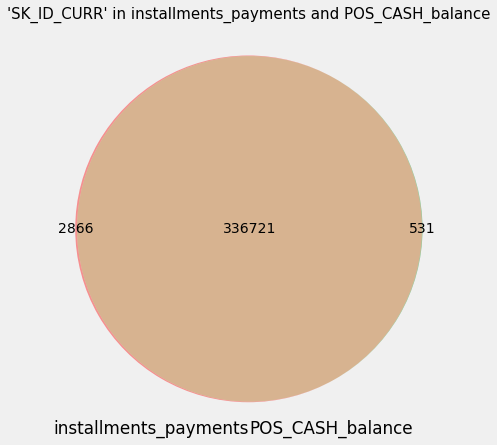

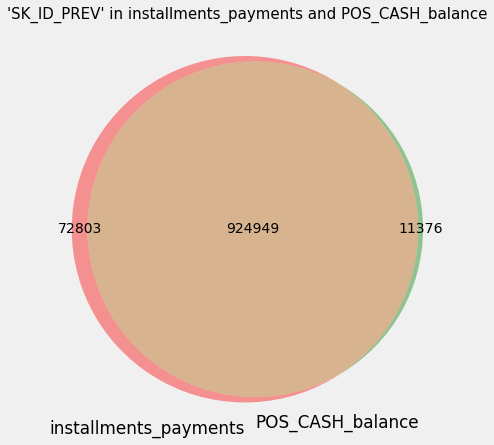

In [30]:
plt.figure(figsize=(10,7))
venn2([set(installments_payments['SK_ID_CURR'].unique()), set(POS_CASH_balance['SK_ID_CURR'].unique())], set_labels = ('installments_payments', 'POS_CASH_balance') )
plt.title("'SK_ID_CURR' in installments_payments and POS_CASH_balance", fontsize=15)
plt.show()

plt.figure(figsize=(10,7))
venn2([set(installments_payments['SK_ID_PREV'].unique()), set(POS_CASH_balance['SK_ID_PREV'].unique())], set_labels = ('installments_payments', 'POS_CASH_balance') )
plt.title("'SK_ID_PREV' in installments_payments and POS_CASH_balance", fontsize=15)
plt.show()

In [31]:
#columns = ['SK_ID_CURR', 'SK_ID_PREV']
columns = ['SK_ID_CURR']
# Iterate through the variables names
for var in POS_CASH_balance_agg.columns.levels[0]:
    # Skip the id name
    #if var != 'SK_ID_CURR' and var != 'SK_ID_PREV':
    if var != 'SK_ID_CURR':    
        # Iterate through the stat names
        for stat in POS_CASH_balance_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('POS_%s_%s' % (var, stat))

In [32]:
POS_CASH_balance_agg.columns = columns
POS_CASH_balance_agg.head()

,SK_ID_CURR,POS_MONTHS_BALANCE_count,POS_MONTHS_BALANCE_mean,POS_MONTHS_BALANCE_max,POS_MONTHS_BALANCE_min,POS_MONTHS_BALANCE_sum,POS_CNT_INSTALMENT_count,POS_CNT_INSTALMENT_mean,POS_CNT_INSTALMENT_max,POS_CNT_INSTALMENT_min,POS_CNT_INSTALMENT_sum,POS_CNT_INSTALMENT_FUTURE_count,POS_CNT_INSTALMENT_FUTURE_mean,POS_CNT_INSTALMENT_FUTURE_max,POS_CNT_INSTALMENT_FUTURE_min,POS_CNT_INSTALMENT_FUTURE_sum,POS_SK_DPD_count,POS_SK_DPD_mean,POS_SK_DPD_max,POS_SK_DPD_min,POS_SK_DPD_sum,POS_SK_DPD_DEF_count,POS_SK_DPD_DEF_mean,POS_SK_DPD_DEF_max,POS_SK_DPD_DEF_min,POS_SK_DPD_DEF_sum
0,100001,9,-72.555556,-53,-96,-653.0,9,4.000000,4.0,4.0,36.0,9,1.444444,4.0,0.0,13.0,9,0.777778,7,0,7.0,9,0.777778,7,0,7.0
1,100002,19,-10.000000,-1,-19,-190.0,19,24.000000,24.0,24.0,456.0,19,15.000000,24.0,6.0,285.0,19,0.000000,0,0,0.0,19,0.000000,0,0,0.0
2,100003,28,-43.785714,-18,-77,-1226.0,28,10.107142,12.0,6.0,283.0,28,5.785714,12.0,0.0,162.0,28,0.000000,0,0,0.0,28,0.000000,0,0,0.0
3,100004,4,-25.500000,-24,-27,-102.0,4,3.750000,4.0,3.0,15.0,4,2.250000,4.0,0.0,9.0,4,0.000000,0,0,0.0,4,0.000000,0,0,0.0
4,100005,11,-20.000000,-15,-25,-220.0,10,11.700000,12.0,9.0,117.0,10,7.200000,12.0,0.0,72.0,11,0.000000,0,0,0.0,11,0.000000,0,0,0.0


In [33]:
POS_CASH_balance_agg.shape

(337252, 26)

In [34]:
#install_credit_POS_agg = install_credit_agg.merge(POS_CASH_balance_agg, how='left', on='SK_ID_PREV')
install_credit_POS_agg = install_credit_agg.merge(POS_CASH_balance_agg, how='left', on='SK_ID_CURR')

In [35]:
install_credit_POS_agg.shape

(339587, 156)

In [36]:
install_credit_POS_agg = reduce_mem_usage(install_credit_POS_agg)

Memory usage of dataframe is 221.19 MB
Memory usage after optimization is: 199.17 MB
Decreased by 10.0%


In [37]:
gc.collect()

3707

In [38]:
#previous_application_agg.to_csv('prev_appln.csv', index=False)
install_credit_POS_agg.to_csv('install_credit_POS_agg.csv', index=False)